### Draw all bounding boxes for detected object

In [2]:
from glob import glob
from pathlib import Path

import pandas as pd
import numpy as np
import cv2

from PIL import Image
import matplotlib.pyplot as plt

from scipy.optimize import linear_sum_assignment


In [3]:
data_path = "../data"

In [4]:
img_width = 1920
img_height = 1200

In [5]:
def from_yolo_to_cor(box, shape):
    img_h, img_w, _ = shape
    # top left
    x1, y1 = int((box[0] - box[2]/2)*img_w), int((box[1] - box[3]/2)*img_h)
    # bottom right
    x2, y2 = int((box[0] + box[2]/2)*img_w), int((box[1] + box[3]/2)*img_h)
    return {"x1": x1, "y1": y1, "x2": x2, "y2": y2}
    
def draw_boxes(img, boxes):
    for box in boxes:
        coords = from_yolo_to_cor(box, (1200, 1920, 3))
        cv2.rectangle(img, (coords['x1'], coords['y1']), (coords['x2'], coords['y2']), (0,255,0), 3)
    plt.figure(figsize=(10,10))
    plt.imshow(img)

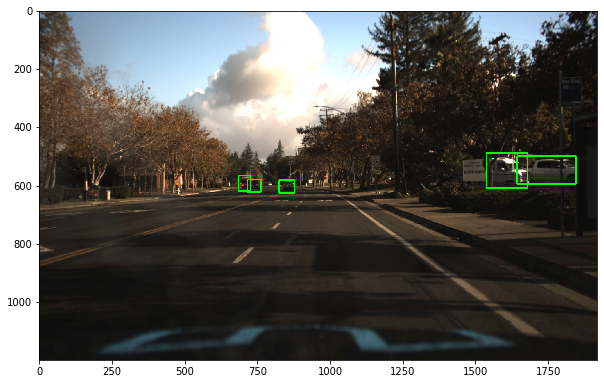

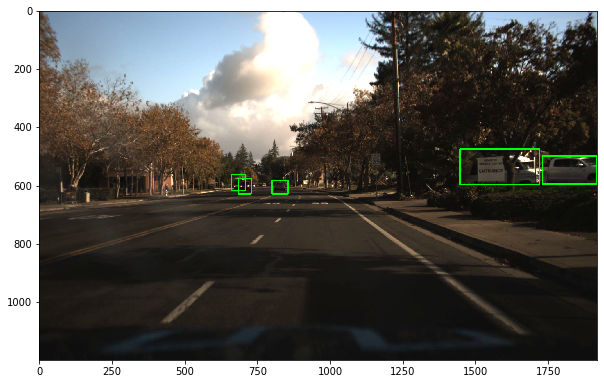

In [6]:
for img in glob(f"{data_path}/*.jpg"):
    image = np.array(Image.open(img))
    boxes = pd.read_csv(f"{data_path}/{Path(img).stem}.txt", delimiter=" ",  names=["category", "x", "y","width", "height"])
    draw_boxes(image, boxes[["x", "y","width", "height"]].values)


## SORT steps

1. Get bounding box detection at t0, predict bounding box using Kalman filter for t1'
2. Using Hungarian/Munkres algorithm get the assignments using IoU score between detected bounding boxes t1 and predicted t1' bounding boxes
3. Update the kalman filter with the assigned prediction t1 and the Kalman model for that bounding box.

### Load two consecutive frames t0 and t1

In [7]:
frame_t0 = pd.read_csv(f"{data_path}/1478019953689774621.txt", delimiter=" ",  names=["category", "x", "y","width", "height"])
frame_t1 = pd.read_csv(f"{data_path}/1478019954186238236.txt", delimiter=" ",  names=["category", "x", "y","width", "height"])

Select only cars for now to run tracking on and select only: x, y, w, h.

In [8]:
frame_t0 = frame_t0[frame_t0['category'] == 0][["x", "y", "width", "height"]]
frame_t1 = frame_t1[frame_t1['category'] == 0][["x", "y", "width", "height"]]

### Kalman filter using constant velocity model
Using the bounding box, predict the bounding box for the next timestep using constant velocity model

In [9]:
#import sys
#!{sys.executable} -m pip install pykalman

In [10]:
from pykalman import KalmanFilter

In [11]:
cx, cy, box_width, box_height = frame_t0.values[0]

Velocities initialized to 0 in the state vector, our filter will optimize these.

In [12]:
vy, vx ,v_width, v_height = 0, 0, 0, 0

In [13]:
frame_0_state_vector = [cx*img_width, cy*img_height, box_width*img_width, box_height*img_height, vx, vy, v_width, v_height]
frame_0_state_vector

[740.0, 600.0, 48.0, 44.0, 0, 0, 0, 0]

Initialiaze the covariance P matrix, bigger the value bigger the expected noise, will be adjusted by the filter. Same size as the state vector, one covariance per variable.

Called `initial_state_covariance` in pykalman (default identity matrix)

In [14]:
p = np.diag(np.ones(8))*10
p

array([[10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 10.]])

Set up the transition matrix F

Called `transition_matrices` in pykalman, `A`

In [35]:
dt = np.ones(4) * 0.01

In [36]:
A = np.diag(dt, 4)

In [37]:
np.fill_diagonal(A, 1)
A

array([[1.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.01],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

Process covariance, noise matrix

Pykalman `transition_covariance` also `Q`

In [21]:
Q = np.diag(np.ones(8)) * 0.01
Q

array([[0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01]])

Measurement noise, the pixel error we can expect from our Yolov3 predictions in x and y

cx and cy noise: 1 pixel

width and height noise: 10 pixels

`observation_covariance` in Pykalman `R`

In [22]:
R = np.diag(np.ones(4))
R[2][2] = 10
R[3][3] = 10
R

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0., 10.,  0.],
       [ 0.,  0.,  0., 10.]])

Pykalman can be initialized with [n_dim_obs, n_dim_obs] for observation, and we have 8 observations. This does not need to be explicitly stated when transition matrix etc are defined.

In [34]:
n_timesteps = 2
n_dim_state = 8
n_dim_obs = 4

In [35]:
states = np.zeros((n_timesteps, n_dim_state))
measurements = np.zeros((n_timesteps, n_dim_obs))

In [36]:
states.shape

(2, 8)

In [37]:
measurements.shape

(2, 4)

In [38]:
means, covariances = kf.filter(measurements)

ValueError: shapes (8,1) and (4,) not aligned: 1 (dim 1) != 4 (dim 0)

In [23]:
kf = KalmanFilter(transition_matrices=A, transition_covariance=Q, initial_state_covariance=p)

In [24]:
np.shape(frame_0_state_vector)

(8,)

In [27]:
filtered_state_means, filtered_state_covariances = kf.filter(frame_0_state_vector)

In [29]:
filtered_state_means.shape

(8, 8)

Results are `[cx, cy, box_width, box_height, vx, vy, v_width, v_height]`

In [32]:
filtered_state_means

array([[672.72727273,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [637.89673141,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [444.19103372,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [343.01325546,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [271.62402415,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [222.98556042,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [187.5301064 ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [160.4187912 ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.       

### Hungarian algorithm
https://towardsdatascience.com/computer-vision-for-tracking-8220759eee85

In [16]:
frame_t0.values

array([[0.38541667, 0.5       , 0.025     , 0.03666667],
       [0.44427083, 0.5025    , 0.028125  , 0.03833333],
       [0.83854167, 0.45666667, 0.07291667, 0.1       ],
       [0.90989583, 0.455     , 0.10520833, 0.08      ]])

In [17]:
frame_t1.values

array([[0.36875   , 0.50166667, 0.02291667, 0.04333333],
       [0.43177083, 0.50416667, 0.028125  , 0.03833333],
       [0.82552083, 0.44583333, 0.14270833, 0.10166667],
       [0.95052083, 0.455     , 0.096875  , 0.08      ]])

Create a matrix with pairwise comparison between the bounding boxes in frame t0 (already tracking) and frame t1 (new detections)

In [18]:
h_mat = np.zeros((len(frame_t0.values), len(frame_t1.values)))
h_mat

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Calculate the IOU for bounding box each pair in the matrix.

In [19]:
def bb_intersection_over_union(box_a, box_b):
    #assert box_a['x1'] < box_a['x2']
    #assert box_a['y1'] < box_a['y2']
    #assert box_b['x2'] < box_b['x2']
    #assert box_b['y2'] < box_b['y2']
    
    # determine the (x, y)-coordinates of the intersection rectangle
    x_1 = max(box_a['x1'], box_b['x1'])
    y_1 = max(box_a['y1'], box_b['y1'])
    x_2 = min(box_a['x2'], box_b['x2'])
    y_2 = min(box_a['y2'], box_b['y2'])
    
    if (x_2 - x_1) < 0 or (y_2 - y_1) < 0:
        return 0.0

    # compute the area of intersection rectangle
    intersection_area = (x_2 - x_1 + 1) * (y_2 - y_1 + 1)
    print(intersection_area)

    # compute the area of both the prediction and ground-truth
    # rectangles
    box_a_area = (box_a['x2'] - box_a['x1']) * (box_a['y2'] - box_a['y1'])
    box_b_area = (box_b['x2'] - box_b['x1']) * (box_b['y2'] - box_b['y1'])
    
    print(box_a_area)
    print(box_b_area)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(box_a_area + box_b_area - intersection_area)
    # return the intersection over union value
    if iou >= 0.0 and iou <= 1.0: 
        return iou
    else:
        return 0.0
    

In [20]:
for idx, box_t0 in enumerate(frame_t0.values):
    for idy, box_t1 in enumerate(frame_t1.values):
        if np.array_equal(box_t0, box_t1):
            continue
        box_0 = from_yolo_to_cor(box_t0, (1200, 1920, 3))
        box_1 = from_yolo_to_cor(box_t1, (1200, 1920, 3))
        print(box_0)
        print(box_1)
        iou = bb_intersection_over_union(box_0, box_1)
        h_mat[idx][idy] = iou


{'x1': 716, 'y1': 578, 'x2': 764, 'y2': 622}
{'x1': 686, 'y1': 576, 'x2': 730, 'y2': 628}
675
2112
2288
{'x1': 716, 'y1': 578, 'x2': 764, 'y2': 622}
{'x1': 802, 'y1': 582, 'x2': 856, 'y2': 628}
{'x1': 716, 'y1': 578, 'x2': 764, 'y2': 622}
{'x1': 1448, 'y1': 474, 'x2': 1722, 'y2': 596}
{'x1': 716, 'y1': 578, 'x2': 764, 'y2': 622}
{'x1': 1732, 'y1': 498, 'x2': 1918, 'y2': 594}
{'x1': 826, 'y1': 580, 'x2': 879, 'y2': 626}
{'x1': 686, 'y1': 576, 'x2': 730, 'y2': 628}
{'x1': 826, 'y1': 580, 'x2': 879, 'y2': 626}
{'x1': 802, 'y1': 582, 'x2': 856, 'y2': 628}
1395
2438
2484
{'x1': 826, 'y1': 580, 'x2': 879, 'y2': 626}
{'x1': 1448, 'y1': 474, 'x2': 1722, 'y2': 596}
{'x1': 826, 'y1': 580, 'x2': 879, 'y2': 626}
{'x1': 1732, 'y1': 498, 'x2': 1918, 'y2': 594}
{'x1': 1539, 'y1': 488, 'x2': 1680, 'y2': 608}
{'x1': 686, 'y1': 576, 'x2': 730, 'y2': 628}
{'x1': 1539, 'y1': 488, 'x2': 1680, 'y2': 608}
{'x1': 802, 'y1': 582, 'x2': 856, 'y2': 628}
{'x1': 1539, 'y1': 488, 'x2': 1680, 'y2': 608}
{'x1': 1448,

In [21]:
h_mat

array([[0.18120805, 0.        , 0.        , 0.        ],
       [0.        , 0.39552027, 0.        , 0.        ],
       [0.        , 0.        , 0.44387726, 0.        ],
       [0.        , 0.        , 0.16718964, 0.43283582]])

In [22]:
linear_sum_assignment(-h_mat)

(array([0, 1, 2, 3]), array([0, 1, 2, 3]))